In [79]:
# Load in our libraries
# ml_practice
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.cross_validation import KFold

Feature Exploration, Engineering and Cleaning

이제 우리는 대부분의 커널이 구조화된 방식과 같이 진행해 나갈 것이며, 그것은 먼저 손에 잡히는 데이터를 살펴보고, 가능한 feature enginering 기회를 식별하고, 어떤 범주형 특징을 수치적으로 인코딩하는 것이다

In [80]:

# Load in the train and test datasets
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

# embarked -> 어디에서 배를 탔나
# SibSp -> 배우자나 형제 자매 명 수의 총합
# Parch -> 부모 자식 명 수  

# PClass -> Categorical. 사회경제적 지위. (1에 가까울 수록 높음)
# class	1 = 1st, 2 = 2nd, 3 = 3rd

# Ticket -> 티켓 번호. 
# Fare ->  티켓 가격. 

# Embarked -> C = Cherbourg, Q = Queenstown, S = Southampton

# Cabin ->  해당 사람의 숙소? 가 어디있는지에 대한 값

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


여기에서 기능 엔지니어링 아이디어에 대한 Sina의 매우 포괄적이고 잘 고안된 노트북으로 크레딧을 연장해야하므로 
그의 작업을 확인하십시오.

타이타닉 Best Working Classfier : Sina 제작
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

In [81]:
full_data = [train, test]


train['Name_length'] = train['Name'].apply(len) # 이름의 길이를 저장.. 
test['Name_length'] = test['Name'].apply(len)   # 이름의 길이를 저장..


In [82]:
# Some features of my own that I have added in
# Gives the length of the name


# x가 float이면 0이고 아니면 1 
#선실번호. 
#근데 cabin피쳐는 ..? string인데 왜 float로 한 거지..? 
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x:0 if type(x) ==float else 1)

In [83]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
#print(full_data)
print(type(full_data))

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    

<class 'list'>


In [84]:
# 배우자, 형제자매 + 부모자식 명수 

    
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone'] = 1
    
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] ==1, 'IsAlone'] = 1
    
# Embarked 컬럼의 NULL 제거 

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    

# Fare 컬럼의 모든 NULL값 제거 후 평균값으로 채우고, Categorical Fare 항목 만들기 

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    #평균값..
    
# Create a New feature CategoricalAge
# Categorical Age.. 새로운 feature 추가 
for dataset in full_data:
    age_avg = dataset['Age'].mean() #평균 
    age_std = dataset['Age'].std()  # ???
    age_null_count = dataset['Age'].isnull().sum() #sum??
    age_null_random_list = np.random.randint(age_avg - age_std, 
                                             age_avg + age_std, 
                                             size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)
# 동일 길이로 범주화

# 승객 이름에서 title을 뽑아놓기 위해 

def get_title(name):
    
    title_search = re.search('([A-Za-z]+)\.', str(name))
    # 이름이 string이 아닌 경우로 인식되는 경우가 있는 듯. string으로 바꿈.
    # title이 존재하면 -> 추출해서 리턴 시킴
    
    if title_search:
        return title_search.group(1) #->????
    return ""
    
# passeger들의 이름을 포함한 title 이라는 새로운 feature생성. 
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# 자주 등장하지 않는 모든 feature들을 "Rare"라는 그룹으로 바꾼다.

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 
                                                 'Countess', 'Capt', 'Col', 'Don', 'Dr',
                                                 'Major', 'Rev', 'Sir', 'Johnkheer', 'Dona'
                                                ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    #규칙이 있어서 이렇게 한건가.. 
 


for dataset in full_data:

    dataset['Sex'] = dataset['Sex'].map( {'female':0, 'male':1}).astype(float)
    '''
    The lack of NaN rep in integer columns is a pandas "gotcha".
    The usual workaround is to simply use floats.
    '''
    # 타이틀을 매핑 
    
    title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
                                                
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S':0, 'C':1, 'Q':2} ).astype(float) 
    
    # Mapping Fare
    print( "최소값:",dataset['Fare'].min() , "최대값:",dataset["Fare"].max() )
    
        #이 숫자는 뭘 기준으로..?
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[ (dataset['Fare']>7.91) & (dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[ (dataset['Fare']>14.454) & (dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    
    dataset['Fare'] = dataset['Fare'].astype(float) #-> 왜 한거임..?
    # pandas 버전 바뀌면서 dataset['Fare'].astype(int)가 안 됨
    
    dataset.loc[ dataset['Age'] <=16.0, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16.0) & (dataset['Age']<=32.0), 'Age'] = 1
    dataset.loc[ (dataset['Age']>32) & (dataset['Age']<=48), 'Age'] = 2
    dataset.loc[ (dataset['Age']>48) & (dataset['Age']<=64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4;

최소값: 0.0 최대값: 512.3292
최소값: 0.0 최대값: 512.3292


In [85]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

이제 feature를 정리하고 관련 정보를 추출하고 범주형 열을 삭제했습니다. 

이제 우리의 기능은 모두 숫자, 즉 기계 학습 모델에 적합한 형식이 되어야 합니다. 
하지만 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포도를 생성합니다.


In [87]:

train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1.0,1,0,0.0,0.0,23,0,2,0,1.0
1,1,1,0.0,2,0,3.0,1.0,51,1,2,0,3.0
2,1,3,0.0,1,0,1.0,0.0,22,0,1,1,2.0


Pearson 상관 관계 HeatMap입니다.

한 feature이 다른 feature과 얼마나 관련이 있는지 알아보기 위해 feature의 상관 관계를 몇 가지 생성해 보겠습니다. 

이를 위해 다음과 같이 heat map를 매우 편리하게 그릴 수 있는 Seaborn 플로팅 패키지를 활용할 예정입니다.

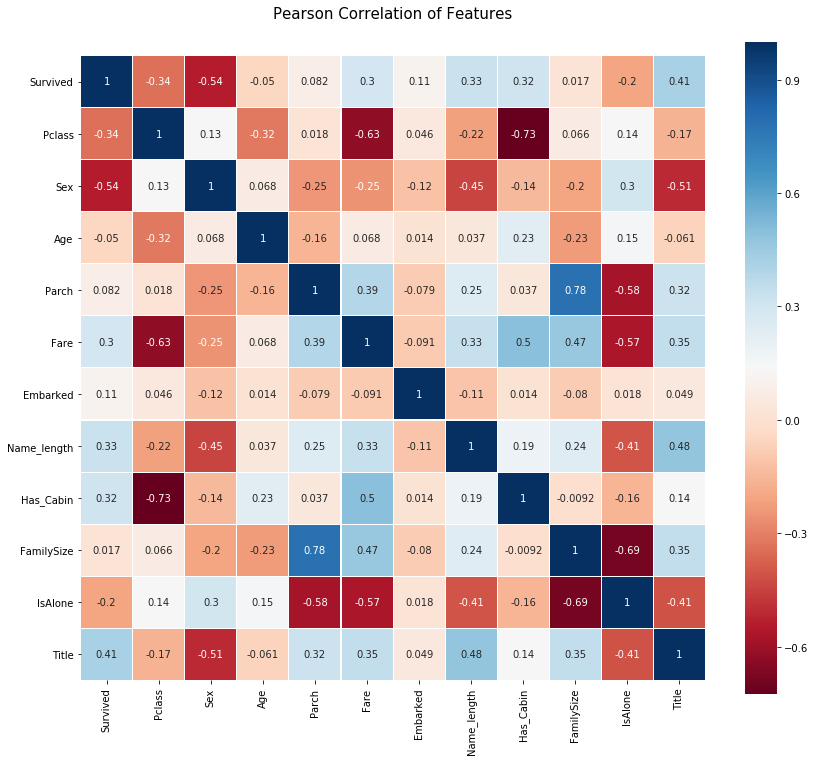

In [89]:

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, 
           cmap = colormap, linecolor='white', annot=True)


Takeaway from Plots

Pearson Correlation 그림에서 알 수 있는 한 가지는 서로 강하게 연관되어 있는 형상이 그리 많지 않다는 것입니다. 

이는 이러한 기능을 학습 모델에 제공하는 관점에서 볼 때 유용합니다. 즉, training set에 중복되거나 불필요한 데이터가 별로 없고 각 기능이 고유한 정보를 제공하게 되어 좋기 때문입니다. 

Family size와 Parch(부모와 자녀)의 두 가지가 가장 상관 관계가 있는 Feature입니다. 이 연습의 목적을 위해 두 가지 기능을 모두 그대로 두겠습니다.

Pair Plots입니다.

마지막으로 한 feature에서 다른 feature으로의 데이터 분포를 관찰할 수 있는 몇 가지 페어 플롯을 생성하겠습니다. 
다시 한번, 우리는 우리를 돕기 위해 Seaborn을 사용합니다.

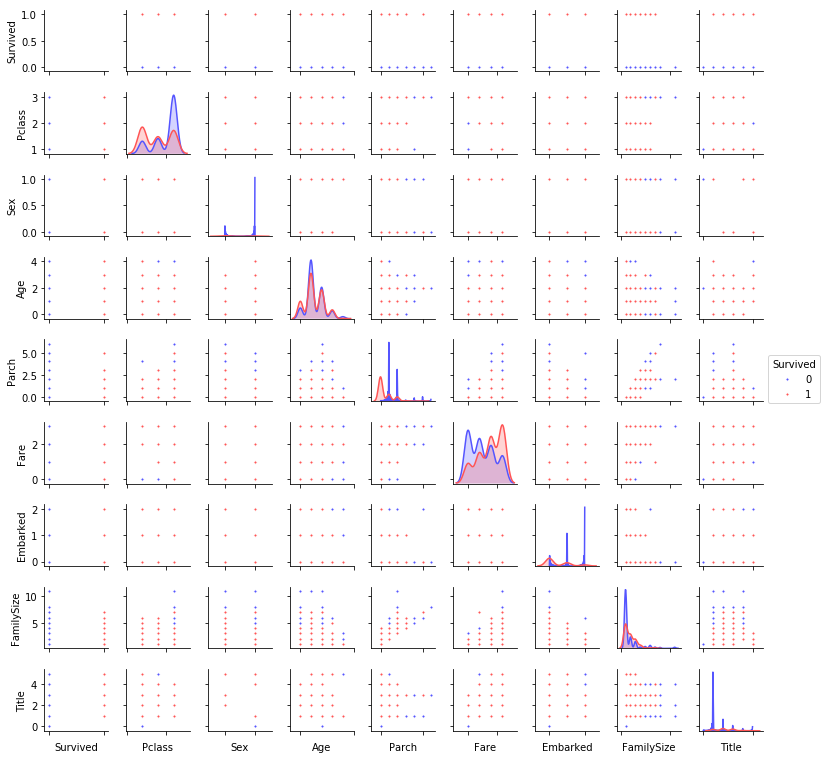

In [97]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked', 
                       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2,
                        diag_kind='kde', diag_kws = dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

#-> 이거 왜 한거지.?

# Some useful parameters which will come in handy later on

모델을 조립하고 쌓습니다.
마지막으로, feature engineering과 포맷에 관해 짧게 알아본 후, 우리는 마침내 이 노트의 핵심에 도달했습니다.

Stacking ensemble을 만듭니다!

Python 클래스를 통해 도움말을 제공합니다.
여기서는 Python의 수업을 사용하여 우리에게 더 편리하게 만들 수 있도록 도와줍니다. 프로그래밍을 시작한 신입생의 경우 일반적으로 OOP(Object-Oriented Programming)와 함께 클래스가 사용되는 것을 들을 수 있습니다. 간단히 말해, 클래스는 객체(구식 핍에 대한 변수)를 작성하기 위한 일부 코드/프로그램을 확장하고 해당 클래스에 특정한 기능과 방법을 구현하는 데 도움이 됩니다.

아래 코드 섹션에서는 기본적으로 모든 Sklearn 분류기에 공통적으로 사용되는 내장 방법(예: 열차, 예측 및 적합)을 확장할 수 있는 클래스 SklearnHelper를 작성합니다. 따라서 5개의 다른 분류기를 호출하려면 동일한 방법을 다섯 번 쓸 필요가 없으므로 중복성이 차단됩니다.

In [ ]:
# Some useful parameters which will come in handy later on

ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # 재사용 위해
NFOLDS = 5 # out-of-fold 예측을 위해
kf = KFold(ntrain, n_folds = NFOLDS, random_state=SEED)

# Sklearn 분류기 확장을 위한 클래스 
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    ####
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

        

        이 사실을 이미 알고 계신 분들을 위해, 그러나 이전에 파이썬에서 클래스나 오브젝트를 만들지 않은 분들을 위해, 위에 주어진 코드가 무엇을 하는지 설명하겠습니다. 기본 분류기를 만들 때 이미 Sklearn 라이브러리에 있는 모델만 사용하므로 해당 클래스를 확장합니다.

def init : 클래스에 대한 기본 생성자를 호출하기 위한 Python 표준입니다. 
즉, 객체(분류기)를 만들려면 clf(sklearn 분류기)와 SEED(Random Seed) 및 Params(분류기용 파라미터)의 파라미터를 지정해야 합니다.

나머지 코드는 단순히 클래스의 메서드이며, 단순히 SKlearn 분류기 내에 이미 존재하는 해당 메서드를 호출합니다.

기본적으로, 우리는 다양한 Sklearn 분류기를 확장하기 위해 Wrapper 클래스를 만들었습니다. 이렇게 하면 staker에 여러 learner를 구현할 때 동일한 코드를 반복해서 쓸 필요가 줄어듭니다.

예측이 불가능합니다.
소개 섹션에서 위에서 언급한 바와 같이, 스택은 기본 분류기의 예측을 2단계 모델에 대한 교육을 위한 입력 자료로 사용합니다. 그러나 기본 모델을 전체 교육 데이터에 대해 교육하고, 전체 테스트 세트에 대한 예측을 생성한 다음, 두 번째 수준의 교육을 위해 출력할 수 없습니다. 이 경우 기본 모델 예측이 이미 테스트 세트를 "보여"하므로 이러한 예측을 제공할 때 오버피팅될 위험이 있습니다.

In [13]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Generating our Base First-Level Models
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

Random Forest classifier
Extra Trees classifier
AdaBoost classifer
Gradient Boosting classifer
Support Vector Machine
Parameters

Just a quick summary of the parameters that we will be listing here for completeness,

n_jobs : Number of cores used for the training process. If set to -1, all cores are used.

n_estimators : Number of classification trees in your learning model ( set to 10 per default)

max_depth : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep

verbose : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.

Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.
기본 1단계 모델을 생성합니다.
이제 5가지 학습 모델을 첫 번째 레벨 분류로 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열됩니다.

랜덤 포리스트 분류기
추가 트리 분류기입니다.
아다부스트 클래시퍼입니다.
Gradient Boosting Classifier입니다.
벡터 머신을 지원합니다.
매개 변수입니다.

완전성을 위해 여기에 나열할 매개변수를 간략하게 요약하면 됩니다.

n_jobs : 교육 프로세스에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.

n_estimators : 학습 모델의 분류 트리의 개수(기본값당 10개로 설정됩니다)

max_deep : 트리의 최대 깊이 또는 노드를 확장할 크기입니다. 너무 높게 설정하면 나무가 너무 깊이 자랄 수 있으므로 너무 많이 들어갈 위험이 있습니다.

상세 내역 : 학습 프로세스 중에 텍스트를 출력할지 여부를 제어합니다. 값이 0이면 모든 텍스트가 억제되고 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됩니다.

공식 Sklearn 웹사이트를 통해 자세한 설명을 확인하시기 바랍니다. 여기에서 다른 유용한 매개 변수를 모두 사용하여 재생할 수 있습니다.

In [14]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

Furthermore, since having mentioned about Objects and 
classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

또한, OOP 프레임워크 내의 개체 및 클래스에 대해 언급했으므로 앞에서 정의한 Helper Sklearn 클래스를 통해 5가지 학습 모델을 나타내는 5가지 개체를 만들겠습니다.



In [15]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
#rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
#et = SklearnHelper(clf=ExtraTreeClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
#ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_paraam)
#gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=S)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [16]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier


print("Training is complete")
